# Final Project - Image Captioning
Apply two different approaches, CNN + LSTM and ResNet + GRU, to automatically generate captions for images. Use Flickr 8k Dataset and pretrained deep models, as needed, to demonstrate the approaches. You must compare the performances of the two approaches by computing their BLEU scores.
## CNN + LSTM

In [1]:
import numpy as np
from glob import glob
import cv2
import tensorflow as tf
import visualkeras
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.layers as lay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, GRU, RepeatVector, TimeDistributed
import os
import matplotlib.pyplot as plt

In [2]:
images_path = r'E:\NEU\Courses\22Spring\INFO7375_ST in AI\Final_Project_Zifeng_Jiang\Images\*.jpg'
images = glob(images_path)

caption_path = 'captions.txt'
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')
captions = captions[1:]

In [3]:
# This variable is how many images that we will work on ( you can use the full dataset if you have good gpu and ram)
samp = 1500

In [4]:
from tensorflow.keras.applications import VGG16

# load vgg16 model
cnn = VGG16()
# restructure the model
cnn = Model(inputs = cnn.inputs, outputs = cnn.layers[-2].output)
# summarize
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Data Preprocessing and feature extraction

In [5]:
# Reading the images and extract the features
imgs = {}
l = 0
for i in images:
    if l == samp:
        break
    k = i.split('\\')[-1]

    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img.reshape(1,224,224,3)
    pred = cnn.predict(img).reshape(4096,)

    imgs[k] = pred
    l += 1

In [6]:
caps = {}
for cap in captions:
    try:
        a = cap.split(',')
        path = a[0]
        cape = a[1][:-2]
    except:
        continue
    
    if path in imgs:
        if path not in caps:
            caps[path] = [cape]
        else:
            caps[path].append(cape)

In [7]:
for i,c in caps.items():
    for cc in range(len(c)):
        p = c[cc].lower()
        k = '<sos> ' + p + ' <eos>'
        caps[i][cc] = k

In [8]:
# making a vocabulary dictionary with position
vacob ={}
for i,c in caps.items():
    for cc in range(len(c)):
        words = caps[i][cc].split()
        for w in words:
            if w not in vacob:
                vacob[w] = len(vacob) + 1

In [9]:
for i,c in caps.items():
    for cc in range(len(c)):
        words = caps[i][cc].split()
        encoded = []
        for w in words:
            encoded.append(vacob[w])
        caps[i][cc] = encoded

In [10]:
m = 0
for i,c in caps.items():
    for cc in c:
        if m < len(cc):
            m = len(cc)

In [11]:
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [12]:
x_img = []
yin = []
yout = []

for i,c in caps.items():
    for c2 in c:
        for g in range(1,len(c2)):
            yi = [c2[:g]]
            yo = c2[g]

            in_seq = pad_sequences(yi, maxlen = m, padding = 'post', truncating = 'post')[0]
            out_seq = to_categorical([yo], num_classes = len(vacob) + 1)[0]

            x_img.append(imgs[i])
            yin.append(in_seq)
            yout.append(out_seq)

In [13]:
x_in = np.array(x_img)
y_in = np.array(yin)
y_out = np.array(yout)

In [14]:
print(x_in.shape,y_in.shape,y_out.shape)

(86349, 4096) (86349, 35) (86349, 4319)


In [15]:
inputs1 = Input(shape=(4096,))
drop_1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(drop_1)

inputs2 = Input(shape=(m,))
embed1 = Embedding(input_dim = len(vacob) + 1, output_dim = 128, input_length = m, mask_zero=True)(inputs2)
drop_2 = Dropout(0.5)(embed1)
se3 = LSTM(256)(drop_2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(len(vacob) + 1, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 128)      552832      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

In [16]:
model.fit([x_in, y_in], y_out, batch_size = 32, epochs = 100)

Epoch 1/100
2699/2699 [==============================] - 27s 6ms/step - loss: 4.5941 - accuracy: 0.2456
Epoch 2/100
2699/2699 [==============================] - 17s 6ms/step - loss: 3.7974 - accuracy: 0.3124
Epoch 3/100
2699/2699 [==============================] - 18s 7ms/step - loss: 3.5077 - accuracy: 0.3307
Epoch 4/100
2699/2699 [==============================] - 17s 6ms/step - loss: 3.3202 - accuracy: 0.3426
Epoch 5/100
2699/2699 [==============================] - 18s 7ms/step - loss: 3.1781 - accuracy: 0.3522
Epoch 6/100
2699/2699 [==============================] - 17s 6ms/step - loss: 3.0602 - accuracy: 0.3602
Epoch 7/100
2699/2699 [==============================] - 18s 7ms/step - loss: 2.9646 - accuracy: 0.3664
Epoch 8/100
2699/2699 [==============================] - 17s 6ms/step - loss: 2.8823 - accuracy: 0.3732
Epoch 9/100
2699/2699 [==============================] - 18s 7ms/step - loss: 2.8075 - accuracy: 0.3780
Epoch 10/100
2699/2699 [==============================] - 18s 7m

2699/2699 [==============================] - 17s 6ms/step - loss: 1.7423 - accuracy: 0.5387
Epoch 80/100
2699/2699 [==============================] - 16s 6ms/step - loss: 1.7480 - accuracy: 0.5391
Epoch 81/100
2699/2699 [==============================] - 16s 6ms/step - loss: 1.7348 - accuracy: 0.5401
Epoch 82/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7385 - accuracy: 0.5411
Epoch 83/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7349 - accuracy: 0.5413
Epoch 84/100
2699/2699 [==============================] - 18s 7ms/step - loss: 1.7405 - accuracy: 0.5422
Epoch 85/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7361 - accuracy: 0.5418
Epoch 86/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7343 - accuracy: 0.5402
Epoch 87/100
2699/2699 [==============================] - 17s 6ms/step - loss: 1.7354 - accuracy: 0.5424
Epoch 88/100
2699/2699 [==============================] - 16s 6ms/st

In [17]:
inv_vacob = {v:k for k, v in vacob.items()}

 a man in a blue canoe battling in time of shrubs


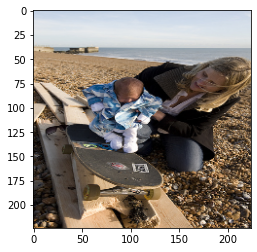

In [18]:
h = 1234
path_img = images[h]
test = cv2.imread(path_img)
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = cv2.resize(test, (224,224))
test = test.reshape(1,224,224,3)
predt = cnn.predict(test).reshape(1,4096)

word = ['<sos>']
word_encoded = []
stement = ''
for i in range(20):
    word_encoded = []
    for w in word:
        word_encoded.append(vacob[w])


    encoded = [word_encoded]
    encoded = pad_sequences(encoded, padding = 'post', truncating = 'post', maxlen = m)

    prediction = np.argmax(model.predict([predt, encoded]))

    sampled_word = inv_vacob[prediction]
    if sampled_word == '<eos>':
        break

    word.append(sampled_word)
    stement += ' ' + sampled_word

plt.imshow(test.reshape(224,224,3))
print(stement)

## BLEU Score Explaination:

The BLEU score compares a sentence against one or more reference sentences and tells how well does the candidate sentence matched the list of reference sentences. It gives an output score between 0 and 1.

A BLEU score of 1 means that the candidate sentence perfectly matches one of the reference sentences.

This score is a common metric of measurement for Image captioning models.

**BLEU-n** is just the geometric average of the n-gram precision.

For example, **BLEU-1** is simply the **unigram precision**, **BLEU-2** is the **geometric average of unigram and bigram precision**, **BLEU-3** is the **geometric average of unigram, bigram, and trigram precision** and so on.

Having said that, if you want to compute specific **n-gram BLEU scores**, you have to pass a weights parameter when you call **corpus_bleu** . Note that if you ignore passing this weights parameter, then by default BLEU-4 scores are returned, which is what happening in the evaluation here.

In [19]:
from nltk.translate.bleu_score import sentence_bleu

In [20]:
allcaps = {}
for cap in captions:
    try:
        a = cap.split(',')
        path = a[0]
        cape = a[1][:-2]
    except:
        continue
    
    if path not in allcaps:
        allcaps[path] = [cape]
    else:
        allcaps[path].append(cape)

In [21]:
for cap in allcaps:
    if cap == images[h].split('\\')[-1]:
        refsent = allcaps[cap]

In [22]:
candidate = stement[1:]
reference = []
for ref in refsent:
    reference.append(ref.split())

In [23]:
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate)))
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
#print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
#print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
#print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

BLEU score -> 1.0350003944289303e-231
Individual 1-gram: 0.104167


E:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
E:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
E:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
